# Comparison of Various Methods for Analyzing Hyperspectral Cathodoluminescence Data

Notebook from some reseach with Oak Ridge National Laboratory (ORNL)

In this notebook, we investigate various methods for extracting information from hyperspectral cathodoluminescence (CL) datasets. For excitonic structures, such as the perovskite sample used in this notebook, curve fitting is quite effective, but it can pose problems that are specific to the dataset, and so it is often difficult to generalize and usually requires *ad hoc* additions to the code. Moreover, often exact numbers are not needed to gain insight into the physics of the sample, so qualititative information can often suffice.

Here, we investigate how various analysis methods respond to CL data. We apply curve fitting, non-negative matrix factorization (NMF), and a variational autoencoder (VAE) to a hyperspectral CL dataset. The results may be summarized as follows:

1. Curve fitting is often tedious but provides maximal information; consequently it is the preferred method when precise quantitative infomation from the dataset is required
2. NMF is able to extract intensity plots that match up very will with those that curve fitting provides, even when peaks overlap
3. Since NMF is effective at extracting the intensity plots, we can focus in on one peak in the spectra and reduce the data from a three parameter space (intensity, center, full width half maximum (FWHM)) to a two parameter space by normalizing each spectrum
4. We can use two latent variables in a variational autoencoder (one for each parameter) to attempt to extract qualititative information about the remaining two parameters that NMF does not adress.
5. The combination of NMF and VAEs is simpler to work with than curve fitting and can provide much of the same information when peaks do not overlap

Online sources which were helpful in the making of this notebook:

https://github.com/ziatdinovmax/pyroVED

https://towardsdatascience.com/mastering-the-shifts-with-variational-autoencoders-ca609ec84f1

https://nbviewer.jupyter.org/github/mgeier/python-audio/blob/master/plotting/matplotlib-colorbar.ipynb

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mpl_toolkits import axes_grid1
from scipy.signal import find_peaks, savgol_filter
from scipy.ndimage import median_filter
from scipy.optimize import curve_fit
from skimage.restoration import denoise_wavelet
from sklearn.decomposition import NMF, PCA
import pyroved as pv
import torch

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large'

blues = mpl.colors.LinearSegmentedColormap.from_list("", ["black","tab:blue","white"])
reds = mpl.colors.LinearSegmentedColormap.from_list("", ["black","tab:red", "white"])
greens = mpl.colors.LinearSegmentedColormap.from_list("", ["black","tab:green","white"])
oranges = mpl.colors.LinearSegmentedColormap.from_list("", ["black","tab:orange","white"])
cs = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange']

In [2]:
h5 = h5py.File(r'5kV-64pA-hyper-hv-300msdwell_3kx_146x160.h5', 'r')

In [3]:
sem_image = h5['Acquisition1']['ImageData']['Image'][()].squeeze()           # SEM image data
hs_data = h5['Acquisition2']['ImageData']['Image'][()].squeeze()             # Hyperspectral CL data
wavelengths = h5['Acquisition2']['ImageData']['DimensionScaleC'][()]*1e9     # The wavelength values in nanometers.
dim_x = h5['Acquisition2']['ImageData']['DimensionScaleX'][()]               # The x width of a pixel in the CL data

In [4]:
pixels = hs_data.shape[1]*hs_data.shape[2]                                   # Number of pixels in the CL image
spectra = hs_data.transpose(1,2,0).reshape(pixels, hs_data.shape[0])         # Reshape such that a row is one spectrum
orig_spectra = hs_data.transpose(1,2,0).reshape(pixels, hs_data.shape[0])    # Copy of the above array
med_sub_orig_spectra = np.absolute(spectra - np.median(spectra))             # Copy of spectra with median subtracted
print(hs_data.shape, spectra.shape, sem_image.shape, dim_x)

(1024, 160, 146) (23360, 1024) (2880, 2628) 4.5e-07


In [5]:
# Denoising the spectra and removing cosmic rays

denoise_kwargs = dict(multichannel=False,  convert2ycbcr=False, wavelet='sym8',
                      rescale_sigma=False, wavelet_levels=6,    mode='soft')

spectra = np.absolute(spectra - np.median(spectra)).astype('uint16')
spectra = [denoise_wavelet(s, **denoise_kwargs)*65535 for s in spectra]
spectra = [savgol_filter(s, 11, 2) for s in spectra]
spectra = [median_filter(s, size=(15)) for s in spectra] # Note: median filter should not be used if sharp peaks are present

## Curve Fitting

In [6]:
# Get an order of magnitude guess for each parameter to use as the p0 argument in curve_fit
def guesser(x, y, ad_hoc_amp=[], ad_hoc_cen=[], ad_hoc_fwhm=[], **kwargs):
    peaks, props = find_peaks(y, **kwargs)
    indexes = np.argsort(np.concatenate((x[peaks],ad_hoc_cen)))     # Sort the peaks from left to right
    amps = np.concatenate((y[peaks], ad_hoc_amp))[indexes]          # All of the amplitude values for the spectrum y
    cens = np.concatenate((x[peaks],ad_hoc_cen))[indexes]           # The wavelength values that those peaks occur at
    fwhms = np.concatenate(((x[1]-x[0])*np.round(props['widths'])
                            .astype(int), ad_hoc_fwhm))[indexes]
    sigs = [fwhm/2*np.sqrt(2*np.log(2)) for fwhm in fwhms]          # The standard deviation can be calculated from the FWHM
    return {'amp':amps, 'cen':cens, 'sig':sigs}                     # Dictionary of the relevant quantities for a Gaussian

In [7]:
# Define the function to be fitted
def gauss(x, *params): # *params from guesser
    num_peaks = int(len(params)/3) # The number of Gaussians we must sum up
    y = np.zeros_like(x, dtype='float64')
    for i in range(num_peaks):
        a = params[i]
        c = params[i+1*num_peaks]
        s = params[i+2*num_peaks]
        y += a*np.exp(-1*((x-c)/(2*s))**2)
    return y

In [8]:
gauss_fails = 0

def optimize(x, y, guess, function):
    global gauss_fails
    num_peaks = int(len(guess)/3)
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=guess, maxfev=2000,bounds=
                               [[0 for i in range(num_peaks)]     +[300 for i in range(num_peaks)]             +[0 for i in range(num_peaks)],
                                [np.inf for i in range(num_peaks)]+[550 for i in range(num_peaks//2)]+[810,810]+[90 for i in range(num_peaks)]])
        return popt
    except (RuntimeError,ValueError):
        gauss_fails+=1

In [9]:
# Getting the initial guesses for the parameters
kwargs = dict(prominence=7,width=(7,None), plateau_size=(0,20))
gauss_guesses = [guesser(wavelengths, s, ad_hoc_amp=[400], ad_hoc_cen=[700], ad_hoc_fwhm=[120], **kwargs) for s in spectra]

In [10]:
# Fitting the function to the spectra
gauss_params = [optimize(wavelengths, spectra[i], [item for sublist in gauss_guesses[i].values() for item in sublist], 'gauss') for i in range(np.shape(spectra)[0])]
print(gauss_fails)

169


We get the values for each of the parameters and convert them back to the spatial representation in the following three cells.

In [11]:
gpeak750int = []
gpeak750cen = []
gpeak750fwhm = []

for i in range(len(gauss_params)):
    try:
        n = len(gauss_params[i])
        gpeak750int.append(gauss_params[i][int((n/3)-1)])
        gpeak750cen.append(gauss_params[i][int((2*n/3)-1)])
        gpeak750fwhm.append(2*np.sqrt(2*np.log(2))*gauss_params[i][-1])
    except TypeError:
        gpeak750int.append(500)
        gpeak750cen.append(750)
        gpeak750fwhm.append(50)
        
gpeak750int = np.array(gpeak750int).reshape((hs_data.shape[1],hs_data.shape[2]))
gpeak750cen = np.array(gpeak750cen).reshape((hs_data.shape[1],hs_data.shape[2]))
gpeak750fwhm = np.array(gpeak750fwhm).reshape((hs_data.shape[1],hs_data.shape[2]))

In [12]:
gpeak500int = []
gpeak500cen = []
gpeak500fwhm = []

for i in range(len(gauss_params)):
    try:
        n = len(gauss_params[i])
        gpeak500int.append(gauss_params[i][int((n/3)-3)])
        gpeak500cen.append(gauss_params[i][int((2*n/3)-3)])
        gpeak500fwhm.append(2*np.sqrt(2*np.log(2))*gauss_params[i][-3])
    except TypeError:
        gpeak500int.append(150)
        gpeak500cen.append(500)
        gpeak500fwhm.append(25)
        
gpeak500int = np.array(gpeak500int).reshape((hs_data.shape[1],hs_data.shape[2]))
gpeak500cen = np.array(gpeak500cen).reshape((hs_data.shape[1],hs_data.shape[2]))
gpeak500fwhm = np.array(gpeak500fwhm).reshape((hs_data.shape[1],hs_data.shape[2]))

In [13]:
gpeak700int = []
gpeak700cen = []
gpeak700fwhm = []

for i in range(len(gauss_params)):
    try:
        n = len(gauss_params[i])
        gpeak700int.append(gauss_params[i][int((n/3)-2)])
        gpeak700cen.append(gauss_params[i][int((2*n/3)-2)])
        gpeak700fwhm.append(2*np.sqrt(2*np.log(2))*gauss_params[i][-2])
    except TypeError:
        gpeak700int.append(500)
        gpeak700cen.append(700)
        gpeak700fwhm.append(75)
        
gpeak700int = np.array(gpeak700int).reshape((hs_data.shape[1],hs_data.shape[2]))
gpeak700cen = np.array(gpeak700cen).reshape((hs_data.shape[1],hs_data.shape[2]))
gpeak700fwhm = np.array(gpeak700fwhm).reshape((hs_data.shape[1],hs_data.shape[2]))

## NMF

We use 4 components because it produces sparse plots for the weight of each component as a function of wavelength.

In [14]:
nmf_model = NMF(n_components=4, init='random', max_iter=5000, random_state=5)

In [15]:
W_nmf = nmf_model.fit_transform(med_sub_orig_spectra)
H_nmf = nmf_model.components_

## Plotting

In [16]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs): # See https://nbviewer.jupyter.org/github/mgeier/python-audio/blob/master/plotting/matplotlib-colorbar.ipynb
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Scale bar = 1.8e-05m


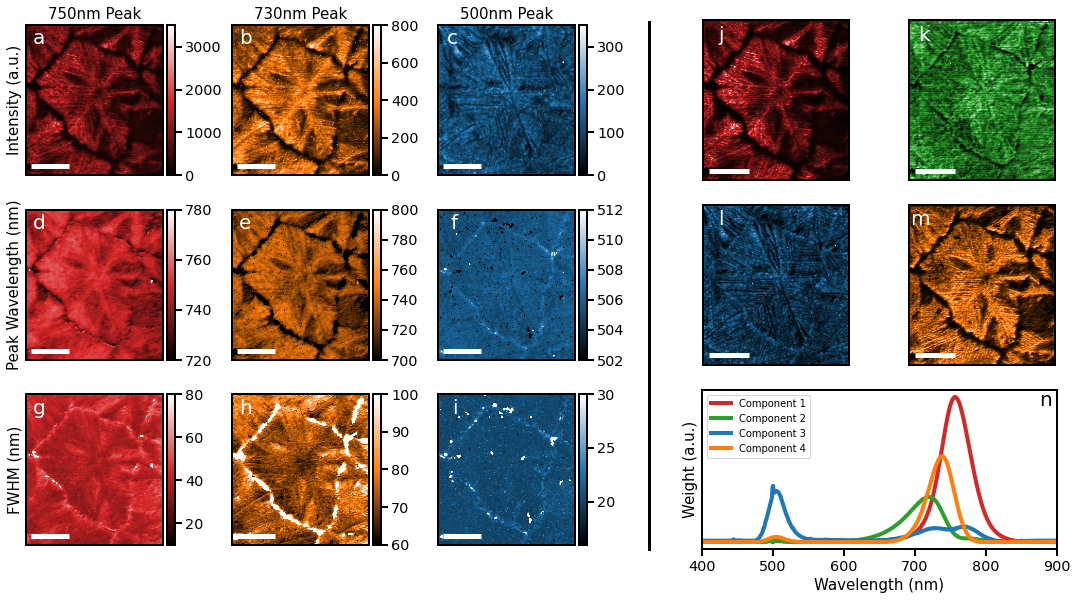

In [17]:
fig = plt.figure(constrained_layout=False)
spec = GridSpec(ncols=6, nrows=3, figure=fig, width_ratios=[1,1,1,.001,1,1])

size=15

g750int = fig.add_subplot(spec[0, 0])
g750intim = g750int.imshow(gpeak750int, vmin=0, vmax=3500, cmap=reds)
add_colorbar(g750intim)
g750int.set_title('750nm Peak', size=size)
g750int.set_ylabel('Intensity (a.u.)', size=size)
g750int.text(20,20, 'a', ha='right', size=20, c='white')

g700int = fig.add_subplot(spec[0, 1])
g700intim = g700int.imshow(gpeak700int, vmin=0, vmax=800, cmap=oranges)
add_colorbar(g700intim)
g700int.set_title('730nm Peak', size=size)
g700int.text(20,20, 'b', ha='right', size=20, c='white')

g500int = fig.add_subplot(spec[0, 2])
g500intim = g500int.imshow(gpeak500int, vmin=0, vmax=350, cmap=blues)
add_colorbar(g500intim)
g500int.set_title('500nm Peak', size=size)
g500int.text(20,20, 'c', ha='right', size=20, c='white')

g750cen = fig.add_subplot(spec[1, 0])
g750cenim = g750cen.imshow(gpeak750cen, vmin=720, vmax=780, cmap=reds)
add_colorbar(g750cenim)
g750cen.set_ylabel('Peak Wavelength (nm)', size=size)
g750cen.text(20,20, 'd', ha='right', size=20, c='white')

g700cen = fig.add_subplot(spec[1, 1])
g700cenim = g700cen.imshow(gpeak700cen, vmin=700, vmax=800, cmap=oranges)
add_colorbar(g700cenim)
g700cen.text(20,20, 'e', ha='right', size=20, c='white')

g500cen = fig.add_subplot(spec[1, 2])
g500cenim = g500cen.imshow(gpeak500cen, vmin=502, vmax=512, cmap=blues)
add_colorbar(g500cenim)
g500cen.text(20,20, 'f', ha='right', size=20, c='white')

g750fwhm = fig.add_subplot(spec[2, 0])
g750fwhmim = g750fwhm.imshow(gpeak750fwhm, vmin=10, vmax=80, cmap=reds)
add_colorbar(g750fwhmim)
g750fwhm.set_ylabel('FWHM (nm)', size=size)
g750fwhm.text(20,20, 'g', ha='right', size=20, c='white')

g700fwhm = fig.add_subplot(spec[2, 1])
g700fwhmim = g700fwhm.imshow(gpeak700fwhm, vmin=60, vmax=100, cmap=oranges)
add_colorbar(g700fwhmim)
g700fwhm.text(20,20, 'h', ha='right', size=20, c='white')

g500fwhm = fig.add_subplot(spec[2, 2])
g500fwhmim = g500fwhm.imshow(gpeak500fwhm, vmin=16, vmax=30, cmap=blues)
add_colorbar(g500fwhmim)
g500fwhm.text(20,20, 'i', ha='right', size=20, c='white')

line = plt.Line2D((.6,.6),(.09, .95), color="k", linewidth=3)
fig.add_artist(line)

nmf_c1 = fig.add_subplot(spec[0, 4])
nmf_c1.imshow(W_nmf[:,0].reshape(160, 146), cmap=reds)
nmf_c1.text(20,20, 'j', ha='right', size=20, c='white')

nmf_c2 = fig.add_subplot(spec[0, 5])
nmf_c2.imshow(W_nmf[:,1].reshape(160, 146), cmap=greens)
nmf_c2.text(20,20, 'k', ha='right', size=20, c='white')

nmf_c3 = fig.add_subplot(spec[1, 4])
nmf_c3.imshow(W_nmf[:,2].reshape(160, 146), vmax=10, cmap=blues)
nmf_c3.text(20,20, 'l', ha='right', size=20, c='white')

nmf_c4 = fig.add_subplot(spec[1, 5])
nmf_c4.imshow(W_nmf[:,3].reshape(160, 146), cmap=oranges)
nmf_c4.text(20,20, 'm', ha='right', size=20, c='white')

nmf_sp = fig.add_subplot(spec[2, 4:6])
for i in range(4):
    nmf_sp.plot(wavelengths, H_nmf[i], lw=4, label='Component {}'.format(i+1), c=cs[i])
nmf_sp.set_xlim(400,900)
nmf_sp.set_yticks([])
nmf_sp.set_xlabel('Wavelength (nm)', size=15)
nmf_sp.set_ylabel('Weight (a.u.)', size=15)
nmf_sp.legend()
nmf_sp.text(875, 95, 'n', size=20)

ims = [g750int, g700int, g500int, g750cen, g700cen, g500cen, g750fwhm, g700fwhm, g500fwhm, nmf_c1, nmf_c2, nmf_c3, nmf_c4]
for item in ims:
    item.set_xticks([])
    item.set_yticks([])
    
for item in ims:
    item.plot([5,45],[150,150], lw=5, c='white', solid_capstyle='butt')
    
fig.set_size_inches(15,8.5)
plt.tight_layout()

print('Scale bar = ' + str(dim_x*40) + 'm')

Left of the vertical line are the results of curve fitting, and right of the vertical line are the results of NMF. NMf extracts the intensity plots from the data, and is much easier to apply.

Since NMF provides the intensity plots, we no longer need that parameter. We can therefore focus in on one peak in the spectra and reduce from a three parameter space to a two parameter space by normalizing each spectrum. Then, we use two latent dimensions in our VAE to try to separate these parameters. In what follows we use the VAE on the 500nm peak to attempt to extract qualitative information about the two remaining parameters and compare it with the results of curve fitting.

## VAE

In [18]:
spectra_n = []
narrow_spectra = np.array(spectra)[:,150:300]
for spectrum in narrow_spectra:
    spectra_n.append((spectrum-np.min(spectrum))/(np.max(spectrum)-np.min(spectrum)))

In [19]:
spectra_n_t = torch.from_numpy(np.array(spectra_n).astype('float64')).float()

In [20]:
n_samples = spectra_n_t.size()[0] # number of spectra
l_signal = spectra_n_t.size()[1] # number of spectral points

train_data = spectra_n_t.clone()
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

In [21]:
in_dim = (l_signal,)
vae = pv.models.iVAE(in_dim, latent_dim=2, invariances=None, sampler_d="gaussian")
trainer = pv.trainers.SVItrainer(vae)

kl_scale = torch.linspace(.001, .01, 50)
for e in range(50):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer.step(train_loader, scale_factor=sc)
    if e//10 == e/10:
        trainer.print_statistics()

Epoch: 1 Training loss: 35.8288
Epoch: 11 Training loss: 34.0299
Epoch: 21 Training loss: 34.0345
Epoch: 31 Training loss: 34.0314
Epoch: 41 Training loss: 34.0344


In [22]:
z_mean, z_sd = vae.encode(spectra_n_t)

## Plotting

[]

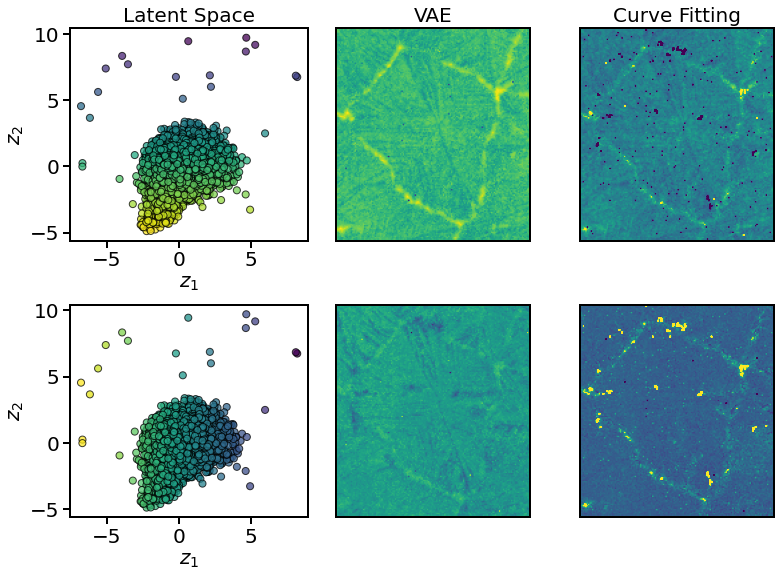

In [23]:
cmap = mpl.cm.get_cmap('viridis_r')

fig = plt.figure(figsize=(13,9))
gs = GridSpec(2,3)
gs.update(wspace=0.025, hspace=.3)

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(z_mean[:,-1], z_mean[:,-2], c=z_mean[:,-2], cmap=cmap, ec='black', alpha=.75, s=50)
ax1.set_xlabel('$z_1$', size=20)
ax1.set_ylabel('$z_2$', size=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_title('Latent Space', size=20)

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(np.reshape(z_mean[:,-2],(160,146)), cmap=cmap)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('VAE', size=20)

ax3 = fig.add_subplot(gs[0,2])
ax3.imshow(gpeak500cen, vmin=502, vmax=510, cmap='viridis')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Curve Fitting', size=20)

ax4 = fig.add_subplot(gs[1,0])
ax4.scatter(z_mean[:,-1], z_mean[:,-2], c=z_mean[:,-1], cmap=cmap, ec='black', alpha=.75, s=50)
ax4.set_xlabel('$z_1$', size=20)
ax4.set_ylabel('$z_2$', size=20)
ax4.tick_params(axis='both', which='major', labelsize=20)

ax5 = fig.add_subplot(gs[1,1])
ax5.imshow(np.reshape(z_mean[:,-1],(160,146)), cmap=cmap)
ax5.set_xticks([])
ax5.set_yticks([])

ax6 = fig.add_subplot(gs[1,2])
ax6.imshow(gpeak500fwhm, vmin=16, vmax=30)
ax6.set_xticks([])
ax6.set_yticks([])

In the figure above, the original plots obtained through curve fitting are shown on the rightmost column.

On the first row, we color the points according to their Z2 dimension to obtain information on redshifting. The central plot is the redshift colormap we obtain with the VAE. it is quite similar to the plots obtained through curve fitting and much of the structure is preserved, indicating the VAE can extract accurate qualitative information about redshifting. One thing to keep in mind is that the shift need not be linearly proportional to Z2

On the second row, we color the points according to their Z1 dimension to obtain information on peak broadening.

The fact that these two latent variables correspond to redshifting and peak broadening is shown below.

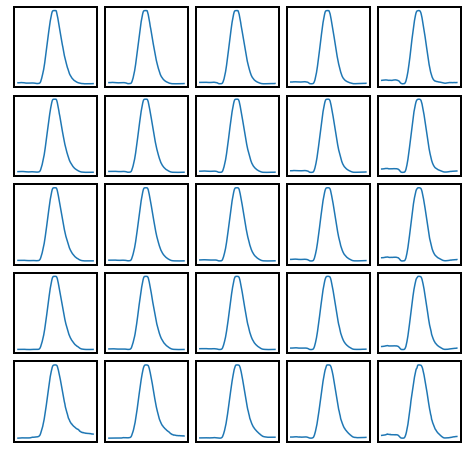

In [24]:
vae.manifold2d(d=5, extent=[-5,5,-5,5]);

Slight peak broadening is observed as Z1 decreases (along the horizontal axis of the manifold). Slight redshifting occurs as Z2 decreases (along the vertical axis of the manifold). The effects are very small, and this is because the effects in the original dataset are very small as well.

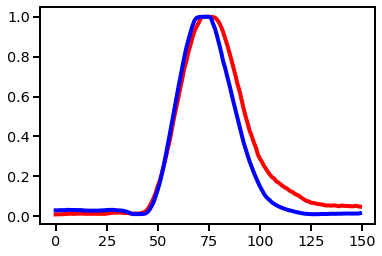

In [25]:
fig, ax = plt.subplots()
ax.plot(vae.decode(torch.tensor([-2., 0.]))[0], c='red', lw=4)
ax.plot(vae.decode(torch.tensor([2., 0.]))[0], c='blue', lw=4)

When changing only latent variable 2 (Z2), we get a clear shift in the central value of the peak.

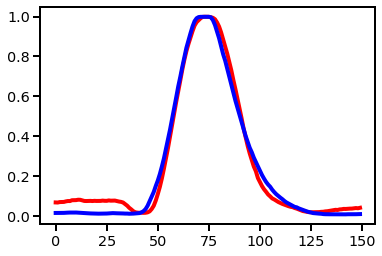

In [26]:
fig, ax = plt.subplots()
ax.plot(vae.decode(torch.tensor([0., 2.]))[0], c='red', lw=4)
ax.plot(vae.decode(torch.tensor([0., -2.]))[0], c='blue', lw=4)

When changing only latent variable 1 (Z1), we see that the blue peak is a bit broader than the red peak on both sides at the base. We can also see, however, that the red peak is a bit broader at the top, so it is possible that this variable is also correlated with some other parameter.